In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
import pickle
from pickle import dump,load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                        Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.applications.resnet_v2 import ResNet101V2
from keras.applications.resnet_v2 import preprocess_input

Using TensorFlow backend.


In [2]:
# Loading documents
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

filename = "TextData/Flickr8k.token.txt"                 # Path of the file contanning descriptions
doc = load_doc(filename)                                 # Load description  
print(doc[0:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [3]:
# Loading documents for processing

def load_descriptions(doc):
    mapping = dict()
    for line in doc.split('\n'):
        tokens = line.split()            # Spliting lines by white space
        if len(line) < 2:                # Consider line having length more than 2
            continue
        image_id, image_desc = tokens[0], tokens[1:]    # Take 1st token as image_id, and rest as description
        image_id = image_id.split('.')[0]               # Extract file name from image_id
        image_desc = ' '.join(image_desc)               # Join the description tokens as sentence
        if image_id not in mapping:
            mapping[image_id] = list()                  # Creating list of descriptions
        mapping[image_id].append(image_desc)            # Store description as dictionary; key:image_id, value: list of descriptions
    return mapping
descriptions = load_descriptions(doc)                   # Load description in required way
print("Loaded: %d" %len(descriptions))                  

Loaded: 8092


In [4]:
# A sample decription 
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [5]:
# Preprocessing text captions

def clean_descriptions(descriptions):
    table = str.maketrans("","",string.punctuation)              # Translation table for removing punctuation
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()                                  # create tokens of words
            desc = [word.lower() for word in desc]               # Convert everything to lower case
            desc = [w.translate(table) for w in desc]            # Remove punctuation using translation table
            desc = [word for word in desc if len(word)>1]        # Remove words like 's', 'a'
            desc = [word for word in desc if word.isalpha()]     # Remove words contaning numbers
            desc_list[i] = ' '.join(desc)                        # Join tokens as sentences
clean_descriptions(descriptions)                                 # Clean description

In [6]:
descriptions["1000268201_693b08cb0e"]               # sample of description after preprocessing

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [7]:
# Get vocabulary of words

def to_vocabulary(descriptions):
    all_desc = set()                                             # Initializing am empty set to store the vocabulary
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]  # Get the words from descriptions 
    return all_desc
vocabulary = to_vocabulary(descriptions)                         
print("Original Vocabulary Size :%d" % len(vocabulary))

Original Vocabulary Size :8763


In [ ]:
# Save description to file

def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key+' '+desc)
    data = "\n".join(lines)
    file = open(filename,'w')
    file.write(data)
    file.close()
save_descriptions(descriptions,"descriptions.txt")

In [8]:
# Load data for training from a file containing the list of training images_id

def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):                    # Process line by line
        if len(line)<1:
            continue
        identifier = line.split('.')[0]             # Get image_id
        dataset.append(identifier)
    return set(dataset)

filename = "TextData/Flickr_8k.trainImages.txt"     # Load training data set
train = load_set(filename)
print("Dataset: %d"% len(train))

Dataset: 6000


In [9]:
images = "Images/"                          # path contains all the images
img = glob.glob(images + '*.jpg')           # Creating list of all the images in the directory

In [10]:
# Getting list of images for training

train_images_file = 'TextData/Flickr_8k.trainImages.txt'                      # Names of the images to be used for training
train_images = set(open(train_images_file,'r').read().strip().split('\n'))    # Reading the image names in a set
train_img = []
for i in img:                                                 # img: list of all the images 
    if i[len(images):] in train_images:                       # get the images in the training set
        train_img.append(i)                                   # Adding to list of training images

In [11]:
# Getting list of images to be used for testing

test_images_file = "TextData/Flickr_8k.testImages.txt"                      # File containing list of images for testing
test_images = set(open(test_images_file,'r').read().strip().split('\n'))    # Reading the file

test_img = []    
for i in img:                                         # img: list of all the images
    if i[len(images):] in test_images:                # Get images for testing
        test_img.append(i)                            # Adding the images in list of test images

In [12]:
# Loading the cleaned description 

def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)                                             # Load the document
    descriptions = dict()
    for line in doc.split('\n'):                                         # Reading every line one by one
        tokens = line.split()                                            # Get tokens
        images_id, images_desc = tokens[0], tokens[1:]                   # First token is image_id and rest image descriptions
        if images_id in dataset:                                         # take images that are in dataset only
            if images_id not in descriptions:
                descriptions[images_id] = list()
            desc = 'startseq ' + ' '.join(images_desc) + ' endseq'       # Join the tokens along with addition of a keyword at begining and end
            descriptions[images_id].append(desc)                         # Adding descriptions in a list
    return descriptions

train_descriptions = load_clean_descriptions('descriptions.txt',train)   
print('Description: train= %d'% len(train_descriptions))

Description: train= 6000


In [13]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size = (299,299))     # Converting all the images to size (299,299) for the model
    x = image.img_to_array(img)                                   # Converting images to numpy array of 3-dimensions
    x = np.expand_dims(x, axis = 0)                               # Add one more dimension
    x = preprocess_input(x)                                       # Preprocess images using preprocess_input() from resnet_v2
    return x

In [14]:
model = ResNet101V2(weights = 'ImagenetWeights/resnet101v2_weights_tf_dim_ordering_tf_kernels.h5',
                   input_shape = (299,299,3))                # Loading the ResNet101V2 model

In [16]:
model_new = Model(model.input, model.layers[-2].output)          # Removing the last layer (output) of model

In [17]:
def encode(image):                                         # Encoding the image into a vector of size (2048,)
    image = preprocess(image)                              # Preprocess the image
    fea_vec = model_new.predict(image)                     # Encode vector using the ResNet101V2 model
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])        # Reshape from (1,2048) to (2048, )
    return fea_vec

In [130]:
from tqdm import tqdm                                # importing for visualization of processing steps
start = time()
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)         # Encode all the training images
print("Time taken in seconds =",time()-start)

100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [07:19<00:00, 13.64it/s]

Time taken in seconds = 439.74570298194885


In [131]:
start = time()
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)        # Encode all the test images
print("Time taken in secinds =", time()-start)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:13<00:00, 13.59it/s]

Time taken in secinds = 73.56557011604309


In [132]:
with open("test_encoded_images.pkl","wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)                       # Saving all the encoded vectors 

In [18]:
test_features = load(open("test_encoded_images.pkl",'rb'))
print("Photos : test = %d" %len(test_features))                      # Load the encoded vectors of image

Photos : test = 1000


In [134]:
with open("train_encoded_images.pkl","wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)                       # Saving training encoded vectors

In [19]:
train_features = load(open("train_encoded_images.pkl",'rb'))
print("Photos : train = %d" %len(train_features))                     # Load the training encoded vectors

Photos : train = 6000


In [20]:
all_train_captions = []                  
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)               # Create a list of all the training captions
len(all_train_captions)

30000

In [21]:
word_count_threshold = 10                             # consider words that occurs atleast 10 times in the corpus
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w,0) + 1

vocab = [w for w in word_counts if word_counts[w]>=word_count_threshold]
print("Preprocessed words %d-->%d" %(len(word_counts),len(vocab)))

Preprocessed words 7578-->1651


In [22]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix                   # Creating a dictionary which maps words into indexes
    ixtoword[ix] = w                   # Creating a dictionary which gives words at corresponding index
    ix += 1

In [23]:
vocab_size = len(ixtoword) + 1        # 1 for appended 0's

In [24]:
def to_line(descriptions):                                    # Get list of descriptions from dictionary of cleaned descriptions
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def max_length(descriptions):                                  # finding the length of description with most words 
    lines = to_line(descriptions)
    return max(len(d.split()) for d in lines)

max_length = max_length(train_descriptions)                    # Get maximum length of description
print("Descriptions length : %d" % max_length)

Descriptions length : 34


In [25]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):     # data generator for model
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:                                                                               # Looping over training images
        for key, desc_list in descriptions.items(): 
            n+=1
            photo = photos[key+'.jpg']                                                     # Get the photo features
            for desc in desc_list:                                                         # Looping over all the decriptions
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]     # Encode the sequence
                for i in range(1,len(seq)):                                                # Split one sequence into multiple x,y pairs
                    in_seq, out_seq = seq[:i],seq[i]                                       # Split into input and output pair
                    in_seq = pad_sequences([in_seq],maxlen = max_length)[0]                # Padding the input sequence
                    
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]          # Encoding the output sequence
                    
                    X1.append(photo)                                                       # Adding photo in a list
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:                                                    # yielding the batch data
                yield [[array(X1),array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n = 0

In [26]:
glove_dir = 'Glove vector weights/glove.6B'                                # Loading the glove vectors downloaded from internet
embeddings_index = {}
f = open(os.path.join(glove_dir,'glove.6B.300d.txt'),encoding = 'utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype = 'float32')
    embeddings_index[word] = coefs
f.close()
print("Found %s word vectors. "%len(embeddings_index))

Found 400000 word vectors. 


In [27]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size,embedding_dim))    # Getting a 300-dimensional vector for each of the words in vocabulary

for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector              # Words that are not in embedding index will be all zeros

In [29]:
inputs1 = Input(shape = (2048,))                                       # Model for training for image captioning
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)
inputs2 = Input(shape = (max_length,))
se1 = Embedding(vocab_size,embedding_dim, mask_zero = True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2,se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size,activation = 'softmax')(decoder2)
model = Model(inputs = [inputs1,inputs2], outputs = outputs)

In [30]:
model.layers[2].set_weights([embedding_matrix])         # Loading the embedding matrix as weights in the model
model.layers[2].trainable = False                       # Making it non-trainable as it was taken from trained glove model vectors

In [31]:
model.compile(loss='categorical_crossentropy',optimizer = 'adam')    # Compiling the model

In [32]:
epochs = 50
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [33]:

generator = data_generator(train_descriptions,train_features,wordtoix,max_length,number_pics_per_batch)
model.fit_generator(generator, epochs=epochs , steps_per_epoch = steps,verbose = 1)
#model.save('model_weights_new/model_'+str(i)+'.h5')

Epoch 1/50
2000/2000 [==============================] - 99s 49ms/step - loss: 4.0492
Epoch 2/50
2000/2000 [==============================] - 98s 49ms/step - loss: 3.3337
Epoch 3/50
2000/2000 [==============================] - 98s 49ms/step - loss: 3.1131
Epoch 4/50
2000/2000 [==============================] - 98s 49ms/step - loss: 2.9763
Epoch 5/50
2000/2000 [==============================] - 99s 49ms/step - loss: 2.8780
Epoch 6/50
2000/2000 [==============================] - 99s 50ms/step - loss: 2.8020
Epoch 7/50
2000/2000 [==============================] - 100s 50ms/step - loss: 2.7421
Epoch 8/50
2000/2000 [==============================] - 99s 50ms/step - loss: 2.6924
Epoch 9/50
2000/2000 [==============================] - 99s 49ms/step - loss: 2.6504
Epoch 10/50
2000/2000 [==============================] - 99s 49ms/step - loss: 2.6156
Epoch 11/50
2000/2000 [==============================] - 100s 50ms/step - loss: 2.5868
Epoch 12/50
2000/2000 [==============================] - 101s

In [34]:
model.save_weights('model_weights_new/model_after50.h5')      # Saving the weight of model after 30 epochs so that it can be used again

In [35]:
model.load_weights('model_weights_new/model_after50.h5')       # Loading weights of model 

In [37]:
with open("test_encoded_images.pkl","rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [38]:
def caption(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence],maxlen= max_length)
        yhat = model.predict([photo,sequence],verbose = 0)                    # Predicting the next word using the model
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == "endseq":                                                   # Breaking loop after reaching end of sentence
            break
    final = in_text.split()    
    final = final[1:-1]
    final = ' '.join(final)
    return final

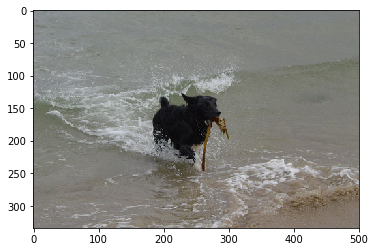

black dog is running through the water


In [86]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print(caption(image))